# Housing Prices

Description:
* Create a model to predict house prices
* The metric that will be used to evaluate how good a model is will be the Root Mean Squared Error(RMSE)

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
og_train = pd.read_csv('train.csv')
og_test = pd.read_csv('test.csv')

## EDA

We begin by exploring the data.

In [3]:
og_train.shape,og_test.shape

((1460, 81), (1459, 80))

In [4]:
og_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We see that a couple of the features have many null entries. We will deal with them later.

In [5]:
#split into numerical and catagorical 
num_col = og_train.select_dtypes(exclude = 'object')
cat_col = og_train.select_dtypes(include = 'object')

print('There are',num_col.shape[1],'numerical features')
print('There are ',cat_col.shape[1],'catagorical features')

There are 38 numerical features
There are  43 catagorical features


To get a better understanding of the relationshop between the independent variables and depend variable we create a heat map.

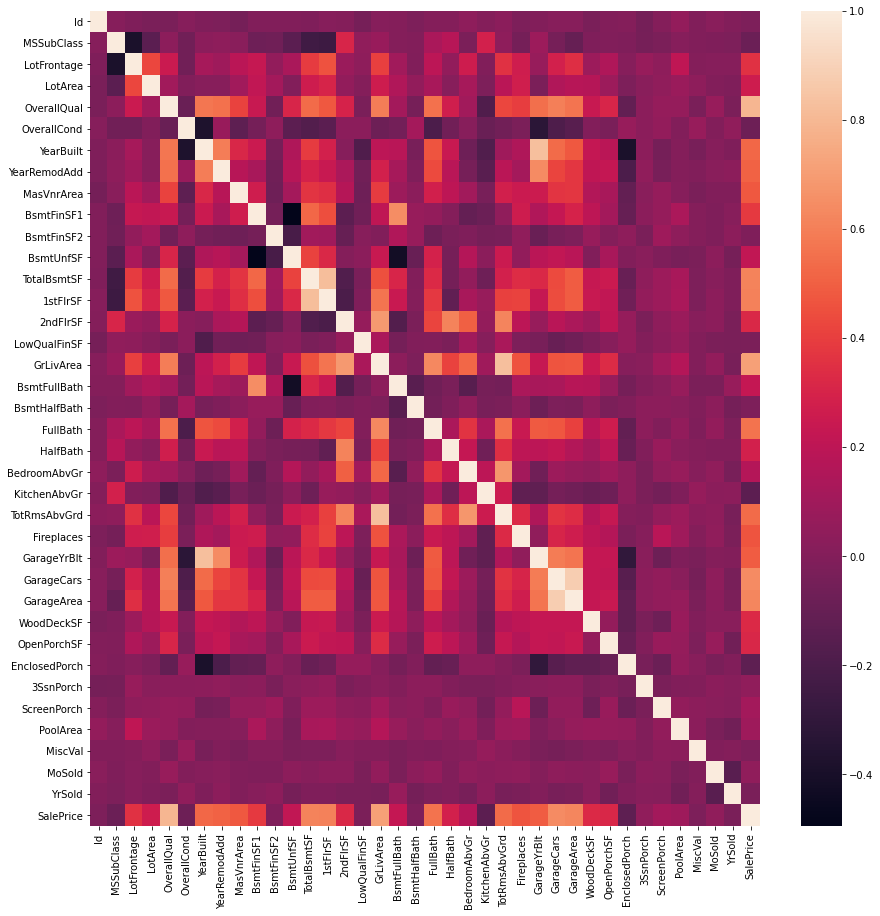

In [6]:
corr_m = num_col.corr()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_m)

Observation:
* Multicollinarity seems to be present between 1stflr and TotalBsmtSF 
* GarageCars and GarageArea also have the same problem

If we were only building a linear regression model we would have to deal with multicollinarity but since I intend to use many models this is not that big of a problem.

Now lets create a heatmap of just the top 10 most highly correlated features

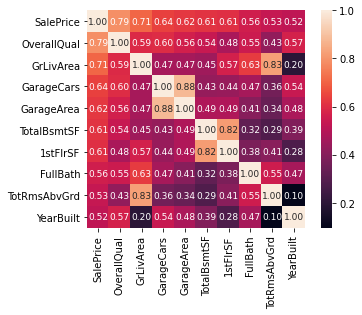

In [7]:
k = 10
cols = corr_m.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(og_train[cols].values.T)
hm = sns.heatmap(cm, annot = True, cbar = True, square = True, fmt = '.2f', yticklabels = cols.values, xticklabels = cols.values, annot_kws={'size':9})

As we can see the features GrlivArea and OveralQual are highly correlated with SalePrice.
We will need to further look into these features later on given their importance to the dependent variable.

Another look at the correlation relationships with SalePrice.

In [8]:
corr_tb = corr_m['SalePrice'].sort_values(ascending = False)
corr_frame = pd.DataFrame(corr_tb)
corr_frame

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Next we look at the distributions of the top features

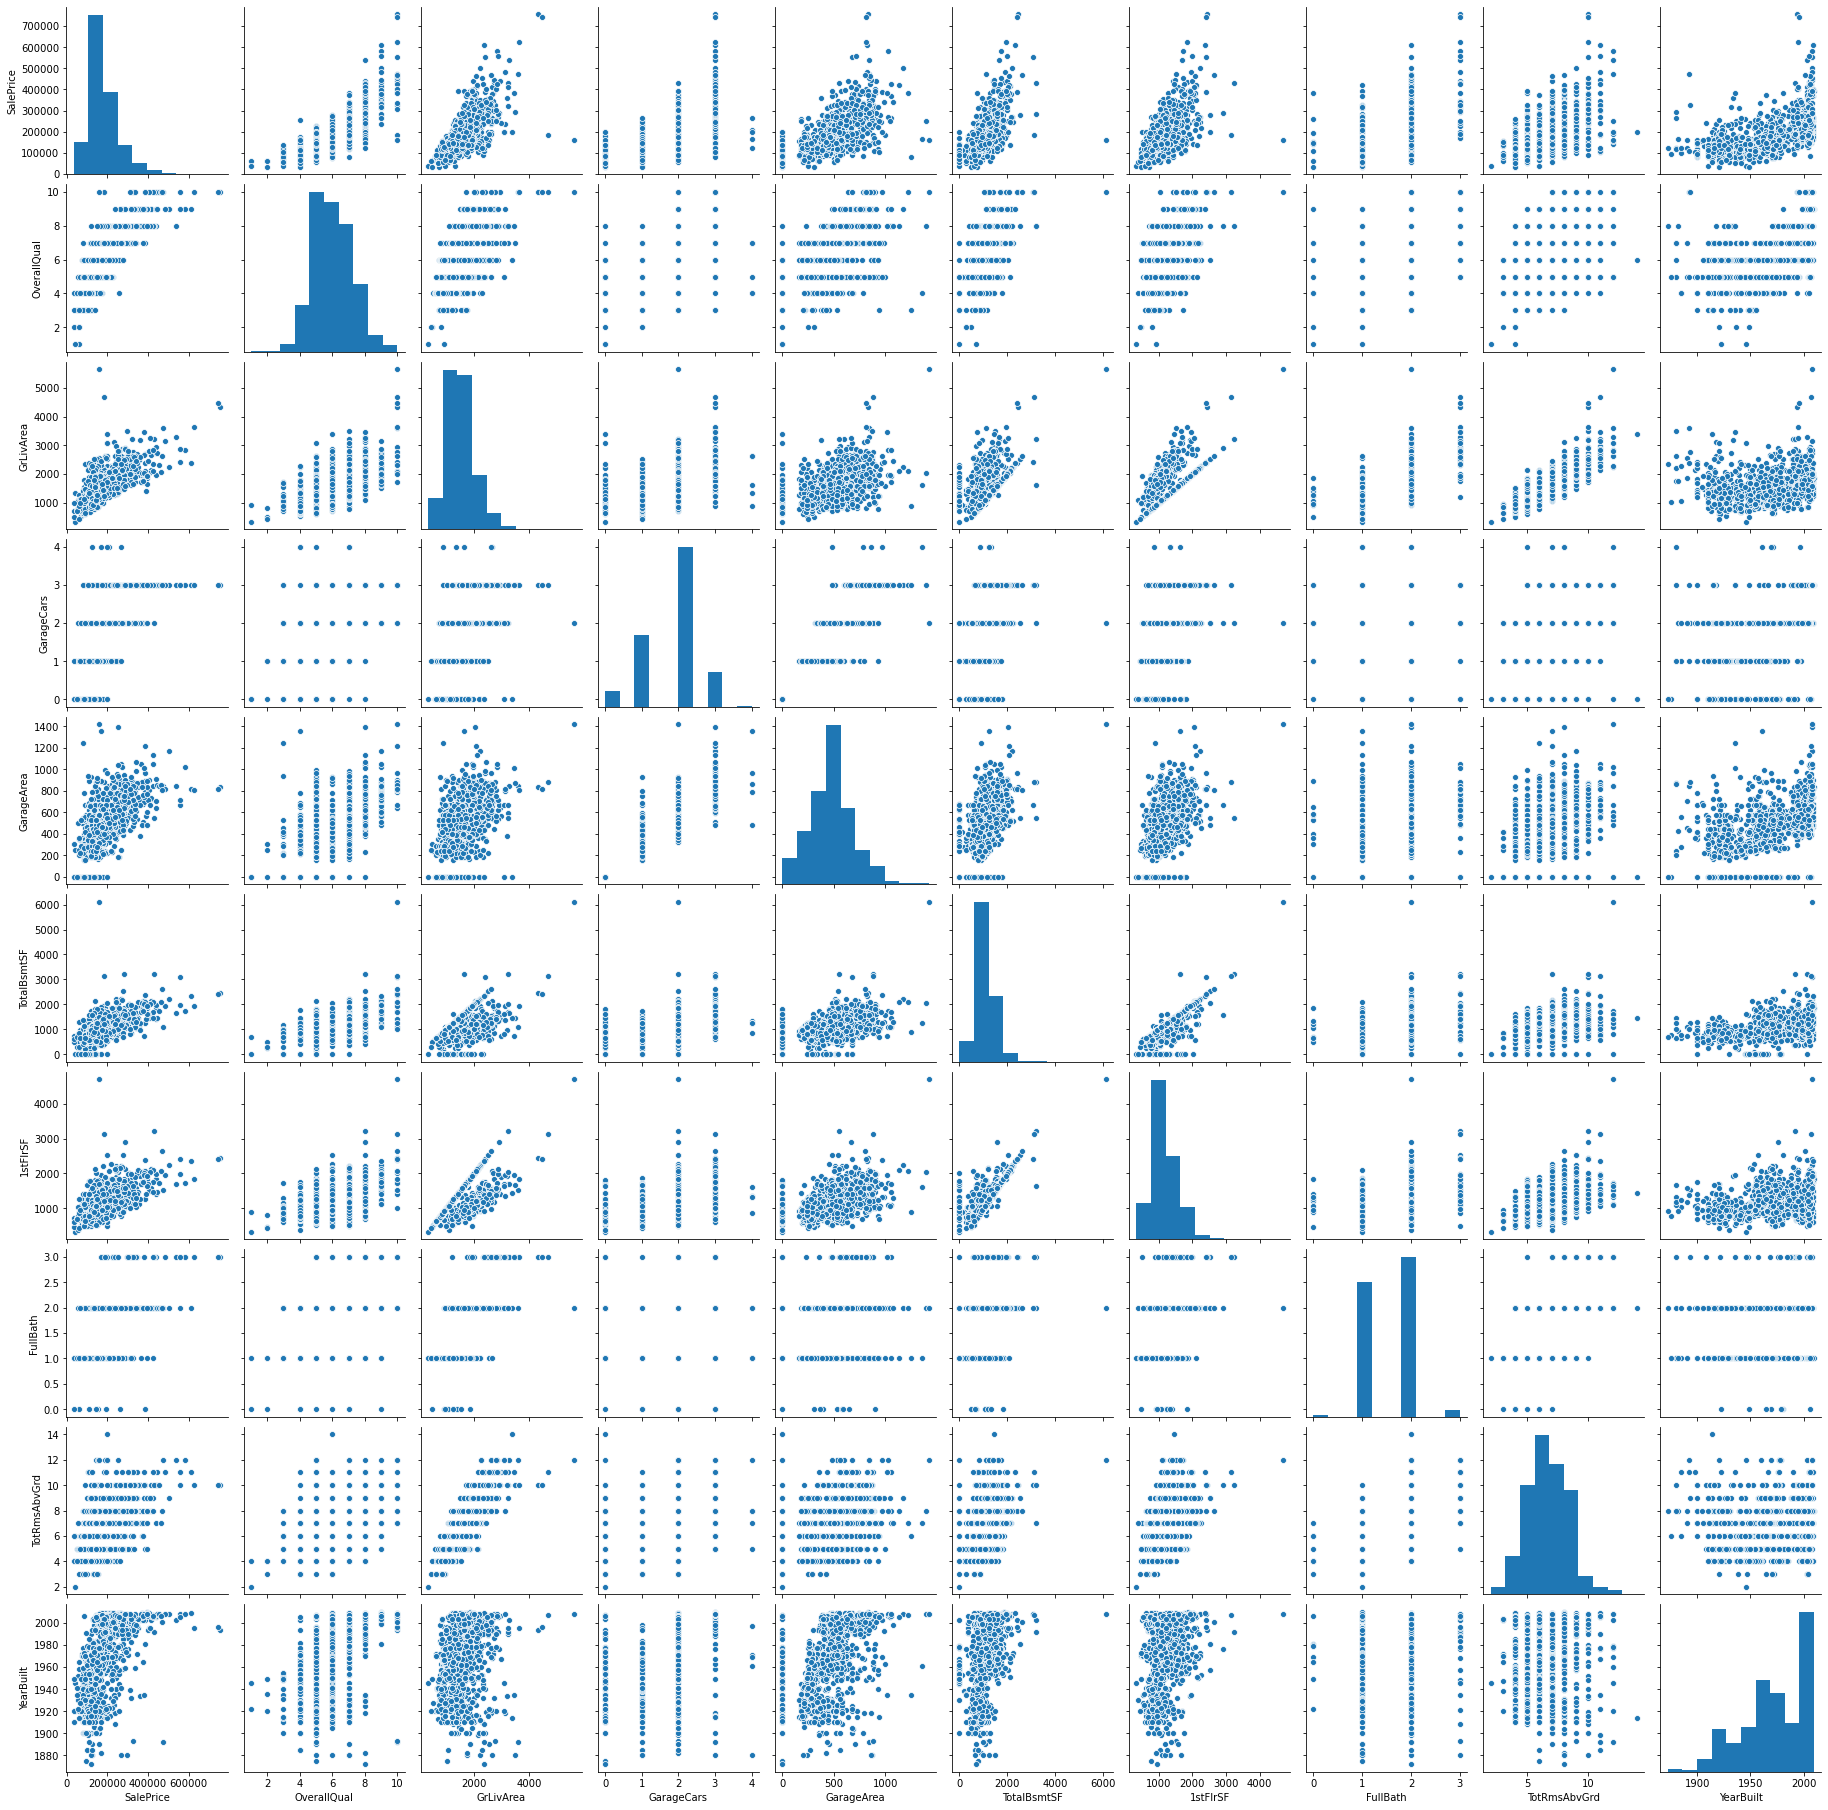

In [9]:
sns.pairplot(og_train[cols])

We now turn back to those highly correlated features and try and find a deeper understanding of their relationship with SalePrice by creating scatterplots.

In [10]:
# create a scatterplot function
def custom_scatterplot(x,y):
    plt.subplots(figsize = (12,8))
    sns.scatterplot(x = x, y = y)

1298    5642
Name: GrLivArea, dtype: int64

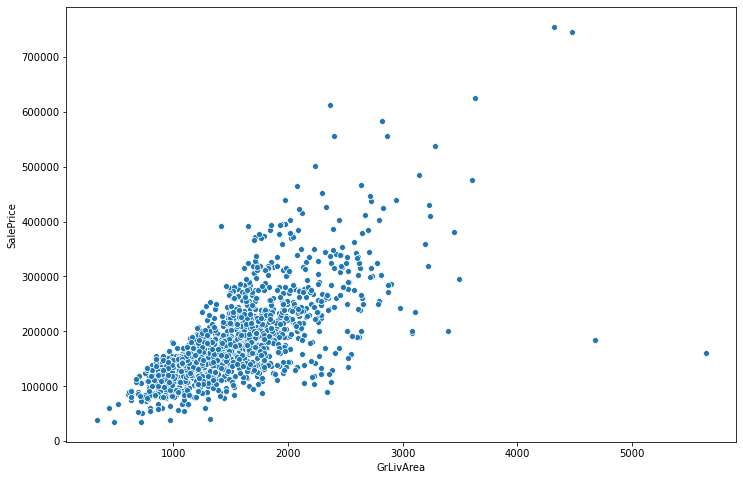

In [11]:
custom_scatterplot(og_train['GrLivArea'],og_train['SalePrice'])
og_train['GrLivArea'].sort_values(ascending = False).head(1)

1298    6110
Name: TotalBsmtSF, dtype: int64

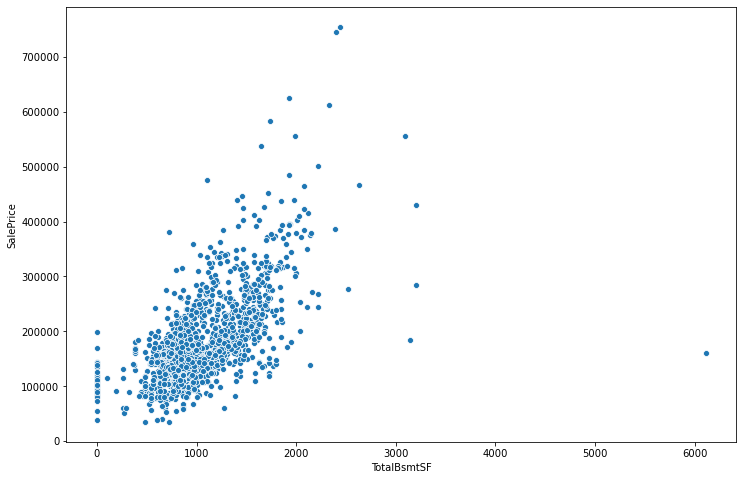

In [12]:
custom_scatterplot(og_train['TotalBsmtSF'],og_train['SalePrice'])
og_train['TotalBsmtSF'].sort_values(ascending = False).head(1)

From just eyeballing the scatterplots we notice some outliers. I remove only two since those were extreme outliers. I will apply a scaler later on to deal with the rest of the the outliers.

In [13]:
#removed outliers
og_train.drop(og_train.index[[1298,523]],inplace = True)

In [14]:
og_train['GrLivArea'].skew()

1.0109917025385513

## Data Cleaning

The next step is to begin cleaning the data. We begin with combining the training and test set. We do this in order to keep the structures of the sets the same.

In [15]:
# combine data sets
train = og_train.copy()
test = og_test.copy()
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice'].reset_index(drop=True)
all_features = pd.concat([train,test]).reset_index(drop = True)
all_features.drop(['SalePrice'],axis = 1 ,inplace = True)
all_features.drop(['Id'],axis = 1,inplace = True)
all_features.shape

(2917, 79)

We first try and get a big picture view of the missing values.

In [16]:
# missing values 
total = all_features.isnull().sum().sort_values(ascending = False)
percent = all_features.isnull().sum()/all_features.isnull().count().sort_values(ascending = False)
missing_data = pd.concat([total,percent],axis = 1 ,keys = ['Total','Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


We notice that some of the features have more than 80% of their values missing. We will completely remove those features.

In [17]:
# get rid of columns with more than 80% missing
all_features = all_features.dropna(thresh = len(all_features)*.8, axis =1)
all_features.shape

(2917, 74)

In [18]:
allna = (all_features.isnull().sum()/len(all_features))*100
allna = allna.drop(allna[allna == 0].index).sort_values()
NA = all_features[allna.index.to_list()]
# split NA into numerical and catagorical
na_num = NA.select_dtypes(exclude = 'object')
na_cat = NA.select_dtypes(include = 'object')

We seperate the features with missing values into numerical and catagorical.

We start with numerical features. I decided to fill the features with the most missing values with the median since outliers won't affect the median. The rest we fill with zero.

In [19]:
all_features['LotFrontage'] = all_features['LotFrontage'].fillna(all_features.LotFrontage.median())
all_features['GarageYrBlt'] = all_features['GarageYrBlt'].fillna(all_features.GarageYrBlt.median())
all_features['MasVnrArea'] = all_features['MasVnrArea'].fillna(0)

all_features[na_num.columns] = all_features[na_num.columns].fillna(0)


In [20]:
na_cat1 = dict(na_cat.isnull().sum())
cols_fill = [(k) for k,v in na_cat1.items() if v <= 4]
all_features[cols_fill] = all_features[cols_fill].fillna(method = 'ffill')
# rerun na_cat to remove the cols above that now have no more na
all_features[na_cat.columns] = all_features[na_cat.columns].fillna('None')


We forward fill the catagorical features with a few missing values since that can offer a more accurate representation. The rest we fill with 'None'.

I also noticed that some features made more since as a catagorical feature than a numerical.

In [21]:
# change certain columns from numerical to catagorical
all_features['MoSold'] = all_features['MoSold'].astype(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MSSubClass'] = all_features['MSSubClass'].astype(str)

## Transformation

Since we will be using regression algorithms its best to fix skewed features.

In [22]:
# Transform skewed features
numeric = all_features.select_dtypes(exclude = 'object')
num_cols = numeric.columns
skew_features = all_features[num_cols].apply(lambda x: skew(x)).sort_values(ascending = False)
high_skew = skew_features[skew_features > .5]
skew_index = high_skew.index
for i in skew_index: 
    all_features[i] = boxcox1p(all_features[i],boxcox_normmax(all_features[i] + 1)) 

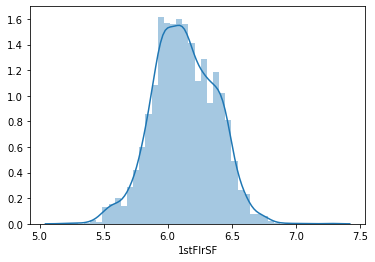

In [23]:
sns.distplot(all_features['1stFlrSF'])

## Feature engineering

We create more features to try and find better insight.

In [24]:
all_features['all_baths'] = all_features['FullBath'] + (all_features['HalfBath']*.5) + all_features['BsmtFullBath'] + (all_features['BsmtHalfBath']*.5)
all_features['total_SF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['yearssinceremodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndflr'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features.shape

(2917, 82)

In [25]:
all_features = pd.get_dummies(all_features).reset_index(drop = True)
all_features.shape

(2917, 316)

In [26]:
X = all_features.iloc[:len(y), :]
Test = all_features.iloc[len(y):, :]
X.shape, Test.shape, y.shape

((1458, 316), (1459, 316), (1458,))

## Building  the models

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

split our train set into a training set and validation set. We do this to test our models.

In [28]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = .3, random_state = 0)

In [29]:
# use scaler to be less sensitive to outliers
scaler = RobustScaler()
X = scaler.fit_transform(X)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
Test = scaler.transform(Test)

In [30]:
# some useful functions
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring = 'neg_mean_squared_error'))
    return rmse
kf = KFold(shuffle = True, random_state = 42, n_splits = 5)

### Linear Regression

In [31]:
scores = {}
#train
lreg = LinearRegression()
lreg.fit(x_train,y_train)
y_pred = lreg.predict(x_val)
score = rmsle(y_val,y_pred)
scores['lreg'] = (score)

In [32]:
scores

{'lreg': 0.12517445295325727}

In [33]:
#final
lreg = LinearRegression()
lreg.fit(X,y)
y_pred = lreg.predict(Test)
final0 = np.expm1(y_pred)

### Ridge Regression

In [34]:
ridge = Ridge()
param_grid = {'alpha':[x for x in range(1, 100)]}
ridge_reg = GridSearchCV(ridge,param_grid,scoring = 'neg_mean_squared_error',cv = kf)
ridge_reg.fit(X,y)
ridge_reg.best_params_,np.sqrt(-ridge_reg.best_score_)


({'alpha': 16}, 0.1104268793850914)

In [35]:
ridge = Ridge(alpha = 16)
ridge.fit(x_train,y_train)
y_pred = ridge.predict(x_val)
score = rmsle(y_val,y_pred)
scores['ridge'] = (score)

In [36]:
#final
ridge = Ridge(alpha = 16)
ridge.fit(X,y)
y_pred = ridge.predict(Test)
final1 = np.expm1(y_pred)
final1.shape

(1459,)

### SVR

In [37]:
svr = SVR()
param_grid = {'C': [c for c in range(10,25)],'epsilon': [.0001,.008,.001,.09],'gamma': [.0005,.0002,.008,.001,.01]}
svr_reg = GridSearchCV(svr, param_grid, scoring = 'neg_mean_squared_error',cv = kf)
svr_reg.fit(X,y)
svr_reg.best_params_, np.sqrt(-svr_reg.best_score_)


({'C': 24, 'epsilon': 0.008, 'gamma': 0.0002}, 0.10978531867868808)

In [38]:
#train
svr = SVR(C = 24, epsilon = .008, gamma = .0002)
svr.fit(x_train,y_train)
y_pred = svr.predict(x_val)
score = rmsle(y_val,y_pred)
scores['svr'] = (score)

In [39]:
#final
svr = SVR(C = 24, epsilon = .008, gamma = .0002)
svr.fit(X,y)
y_pred = svr.predict(Test)
final2 = np.expm1(y_pred)


### Lasso Regression

In [40]:
lasso = Lasso()
param_grid = {'alpha':[.0001,.0005,.0009,.001,.008,.01,.1]}
lasso_reg = GridSearchCV(lasso,param_grid,scoring = 'neg_mean_squared_error',cv = kf)
lasso_reg.fit(X,y)
lasso_reg.best_params_, np.sqrt(-lasso_reg.best_score_)


({'alpha': 0.0005}, 0.10841832707049402)

In [41]:
#train
lasso = Lasso(alpha = .0005)
lasso.fit(x_train,y_train)
y_pred = lasso.predict(x_val)
score = rmsle(y_val,y_pred)
scores['lasso'] = (score)

In [42]:
#final
lasso = Lasso(alpha = .0005)
lasso.fit(X,y)
y_pred = lasso.predict(Test)
final3 = np.expm1(y_pred)


### Stack Regression

In [51]:
stack = StackingRegressor(regressors=[lreg,ridge,svr,gbr,xgb,rf,lasso],meta_regressor = xgb,use_features_in_secondary = True)
stack.fit(np.array(x_train),np.array(y_train))
y_pred = stack.predict(x_val)
score = rmsle(y_val,y_pred)
scores['stack'] = (score)



In [52]:
#final
stack.fit(np.array(X),np.array(y))
y_pred = stack.predict(Test)
final4 = np.expm1(y_pred)

### GBR

In [ ]:
# gbr = GradientBoostingRegressor()
# param = {'n_estimators': [5000,5500,6000],'learning_rate':[.05,.01,.009],'max_depth':[4,6],'min_samples_leaf':[13,15,17],'min_samples_split':[8,10,13]}
# gbr_reg = RandomizedSearchCV(gbr,param_distributions=param, scoring = 'neg_mean_squared_error',n_iter = 10,cv=kf)
# gbr_reg.fit(X,y)
# gbr_reg.best_params_, np.sqrt(-gbr_reg.best_score_)

In [44]:
gbr = GradientBoostingRegressor(n_estimators = 6000,learning_rate= .001,max_depth=4,min_samples_leaf = 15,min_samples_split = 10,max_features = 'sqrt',loss = 'huber',random_state = 42)
gbr.fit(x_train,y_train)
y_pred = gbr.predict(x_val)
score = rmsle(y_val,y_pred)
scores['gbr'] = (score)

In [45]:
gbr = GradientBoostingRegressor(n_estimators = 6000,learning_rate= .001,max_depth=4,min_samples_leaf = 15,min_samples_split = 10,max_features = 'sqrt',loss = 'huber',random_state = 42)
gbr.fit(X,y)
y_pred = gbr.predict(Test)
final5 = np.expm1(y_pred)
final5.shape

(1459,)

### XGB

In [46]:
xgb = XGBRegressor(learning_rate = .01, n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,random_state= 42)
xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_val)
score = rmsle(y_val,y_pred)
scores['xgb'] = (score)



In [47]:
xgb = XGBRegressor(learning_rate = .01, n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,random_state= 42)
xgb.fit(X,y)
y_pred = xgb.predict(Test)
final6 = np.expm1(y_pred)
final6.shape

(1459,)

### Random Forest

In [48]:
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_val)
score = rmsle(y_val,y_pred)
scores['rf'] = (score)

In [49]:
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
rf.fit(X,y)
y_pred = rf.predict(Test)
final7 = np.expm1(y_pred)
final7.shape

(1459,)

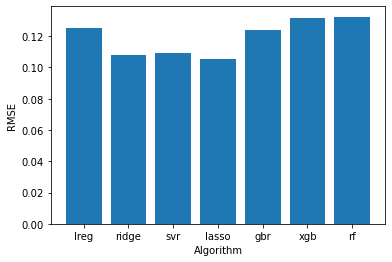

In [50]:
key = scores.keys()
value = scores.values()
plt.bar(key,value)
plt.ylabel('RMSE')
plt.xlabel('Algorithm')
plt.show()

The bar chart above shows the Root Mean Squared Error of each of the algorthems I used. the lower the (RMSE) the better. 

In [ ]:
#blend them together
final = (.05*final7 + .05*final5 + .05*final6 + .35*final4 + .2*final2 + .05*final3 + .25*final1)
final

Finally I decided to blend all the algorithms together. The weight I gave each algorithm was based on the performance of each.

I was able to output an RMSE of 0.1233 

In [ ]:
final_submission = pd.DataFrame({'Id': og_test['Id'], 'SalePrice': final})
final_submission.to_csv('final_submission5.csv', index = False)
final_submission.head(5)